<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
Чем больше картинок в батче, тем менее стохастическими будут наши движения в сторону минимума, и на полном датасете они будут представлять собой полностью направленные "движения" к минимуму

Посмотрим на какую-нибудь картинку:

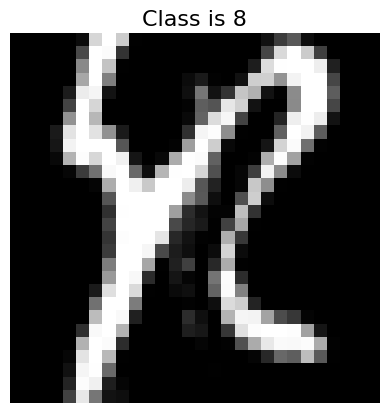

In [ ]:
plt.imshow(trainset[9][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





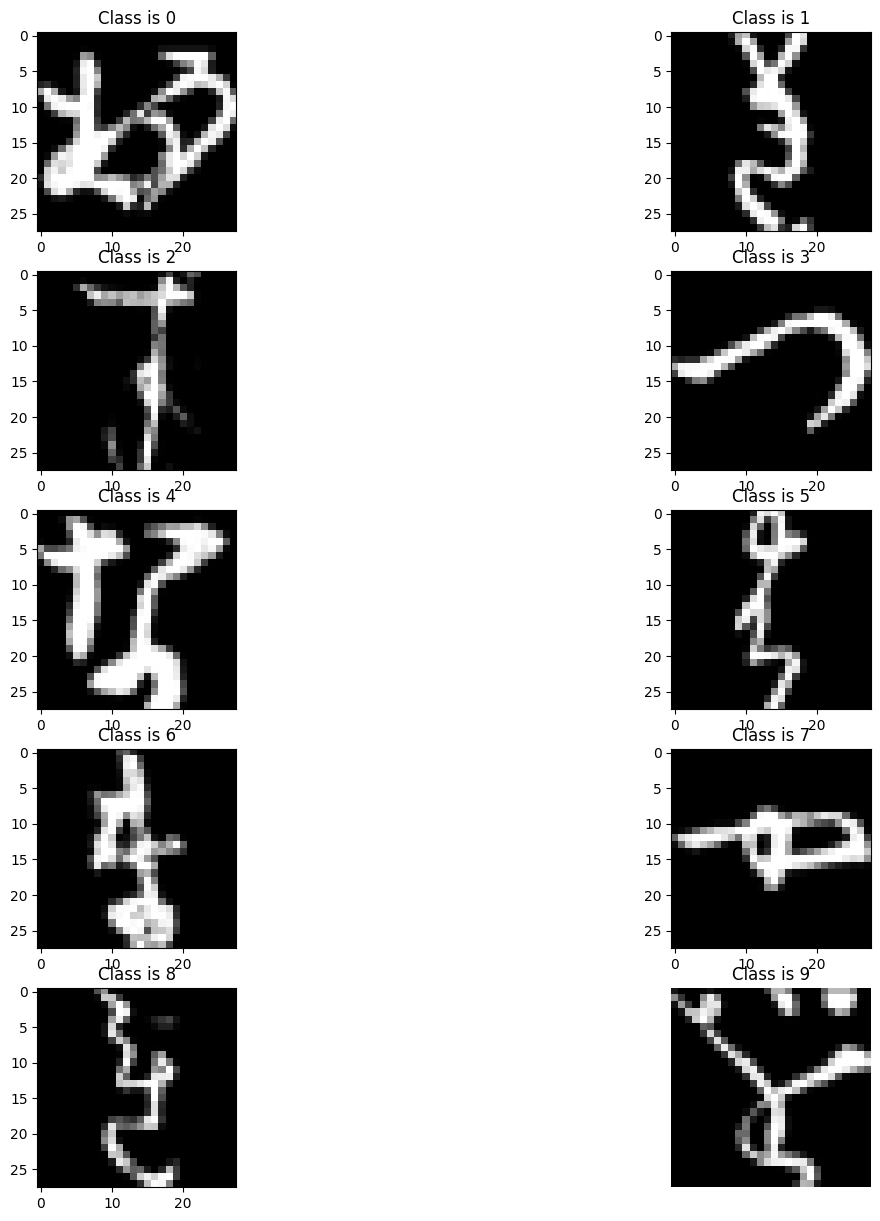

In [ ]:
k, marker = 0, 0
class_number = list(range(10))
fig, ax = plt.subplots(5, 2, figsize=(15, 15))
for row in range(5):
    for col in range(2):
      while True:
        if trainset[k][1] == marker:
          image = trainset[k][0]
          ax[row, col].imshow(image.view(28, 28).numpy(), cmap="gray")
          ax[row, col].set_title(f"Class is {trainset[k][1]}", fontsize=12)
          plt.axis("off");
          break
        k += 1
      marker += 1

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        return logits

В конце для логитов мы не применяем функцию активации, так как в конце будет softmax для перевода в вероятности

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

Так как количество весов определяются создаваемой матрицей, то перемножаем input и output на каждом шаге и суммируем. Смещение будет определяться значением на выходе 

In [ ]:
neural_net = FCNet()

weight, bias = 0, 0
for param in neural_net.parameters():
    if len(param.shape) == 2:
      weight += param.shape[0] * param.shape[1]
    else:
      bias += param.shape[0]

print(f'weight: {weight}, bias: {bias}')

weight: 234752, bias: 394


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []
## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9309
Epoch=2 loss=0.4367
Epoch=3 loss=0.3404
Epoch=4 loss=0.2807
Epoch=5 loss=0.2398
Epoch=6 loss=0.2064
Epoch=7 loss=0.1787
Epoch=8 loss=0.1558
Epoch=9 loss=0.1369
Epoch=10 loss=0.1187


In [ ]:
get_accuracy(fc_net, testloader)

0.8915

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = torch.mean(next(iter(trainloader))[0])
std = torch.std(next(iter(trainloader))[0])
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7320097790>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7320097790>

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

tensor(0.1943) tensor(0.3486)


In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []
## YOUR CODE HERE

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.7473
Epoch=2 loss=0.3308
Epoch=3 loss=0.2343
Epoch=4 loss=0.1771
Epoch=5 loss=0.1377
Epoch=6 loss=0.1083
Epoch=7 loss=0.0844
Epoch=8 loss=0.0652
Epoch=9 loss=0.0498
Epoch=10 loss=0.0378


In [ ]:
get_accuracy(fc_net, testloader)

0.8963

Как изменилась `accuracy` после нормализации?

Не то, чтобы очень значительно, но увеличилось

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE
 
class FCNet(nn.Module):
    def __init__(self, activation):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.block = nn.Sequential(
                       nn.Flatten(),
                       nn.Linear(in_features=28*28, out_features=256),
                       activation(),
                       nn.Linear(in_features=256, out_features=128),
                       activation(),
                       nn.Linear(in_features=128, out_features=10))
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        logits = self.block(x)

        return logits

for activation in [nn.Sigmoid, nn.GELU, nn.Tanh]:
  fc_net = FCNet(activation)
  loss_function = nn.CrossEntropyLoss()
  lr = 0.001
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

  n_epochs = 10
  loss_history = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

  print(f'Accuracy with {activation} = {get_accuracy(fc_net, testloader)}')


Epoch=1 loss=1.5561
Epoch=2 loss=0.7591
Epoch=3 loss=0.5532
Epoch=4 loss=0.4508
Epoch=5 loss=0.3796
Epoch=6 loss=0.3240
Epoch=7 loss=0.2790
Epoch=8 loss=0.2429
Epoch=9 loss=0.2129
Epoch=10 loss=0.1875
Accuracy with <class 'torch.nn.modules.activation.Sigmoid'> = 0.8553
Epoch=1 loss=0.6721
Epoch=2 loss=0.2899
Epoch=3 loss=0.2084
Epoch=4 loss=0.1596
Epoch=5 loss=0.1262
Epoch=6 loss=0.1008
Epoch=7 loss=0.0814
Epoch=8 loss=0.0657
Epoch=9 loss=0.0526
Epoch=10 loss=0.0416
Accuracy with <class 'torch.nn.modules.activation.GELU'> = 0.9033
Epoch=1 loss=0.7783
Epoch=2 loss=0.3833
Epoch=3 loss=0.2565
Epoch=4 loss=0.1825
Epoch=5 loss=0.1345
Epoch=6 loss=0.1015
Epoch=7 loss=0.0763
Epoch=8 loss=0.0563
Epoch=9 loss=0.0422
Epoch=10 loss=0.0308
Accuracy with <class 'torch.nn.modules.activation.Tanh'> = 0.9005


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

GELU лучше всех

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
for optimazer in [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]:  
  fc_net = FCNet(nn.GELU)
  loss_function = nn.CrossEntropyLoss()
  lr = 0.001
  optimizer = optimazer(fc_net.parameters(), lr=3e-4)
  
  n_epochs = 10
  loss_history = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

  print(f'Accuracy with {optimazer} = {get_accuracy(fc_net, testloader)} \n')

Epoch=1 loss=0.6509
Epoch=2 loss=0.2839
Epoch=3 loss=0.2080
Epoch=4 loss=0.1590
Epoch=5 loss=0.1272
Epoch=6 loss=0.0999
Epoch=7 loss=0.0818
Epoch=8 loss=0.0640
Epoch=9 loss=0.0502
Epoch=10 loss=0.0397
Accuracy with <class 'torch.optim.adam.Adam'> = 0.9011 

Epoch=1 loss=0.4459
Epoch=2 loss=0.2424
Epoch=3 loss=0.1808
Epoch=4 loss=0.1392
Epoch=5 loss=0.1089
Epoch=6 loss=0.0866
Epoch=7 loss=0.0686
Epoch=8 loss=0.0536
Epoch=9 loss=0.0421
Epoch=10 loss=0.0323
Accuracy with <class 'torch.optim.rmsprop.RMSprop'> = 0.8915 

Epoch=1 loss=1.3468
Epoch=2 loss=0.8133
Epoch=3 loss=0.6874
Epoch=4 loss=0.6257
Epoch=5 loss=0.5860
Epoch=6 loss=0.5575
Epoch=7 loss=0.5356
Epoch=8 loss=0.5175
Epoch=9 loss=0.5023
Epoch=10 loss=0.4890
Accuracy with <class 'torch.optim.adagrad.Adagrad'> = 0.7207 



Остаемся с Adam

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
def my_relu(layer):
  return torch.where(layer >= 0, layer, 0.0)

class CustomReLU(nn.Module):     
  def __init__(self, real_relu):
    super().__init__() #  это надо помнить!
     ## YOUR CODE HERE
      
    self.fc1 = nn.Linear(in_features=28*28, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)
     
    self.flag = real_relu
        

  def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
      if self.flag:
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)
      else:
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = my_relu(x)
        x = self.fc2(x)
        x = my_relu(x)
        logits = self.fc3(x)

      return logits

In [ ]:
for flag in [True, False]:  
  fc_net = CustomReLU(flag)
  loss_function = nn.CrossEntropyLoss()
  lr = 0.001
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

  n_epochs = 10
  loss_history = []
  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

  label = 'Real RELU' if flag else 'Custom RELU'
  print(f'Accuracy with {label} = {get_accuracy(fc_net, testloader)}')


Epoch=1 loss=0.6868
Epoch=2 loss=0.3061
Epoch=3 loss=0.2264
Epoch=4 loss=0.1768
Epoch=5 loss=0.1437
Epoch=6 loss=0.1157
Epoch=7 loss=0.0940
Epoch=8 loss=0.0776
Epoch=9 loss=0.0630
Epoch=10 loss=0.0511
Accuracy with Real RELU = 0.8951
Epoch=1 loss=0.6927
Epoch=2 loss=0.3023
Epoch=3 loss=0.2262
Epoch=4 loss=0.1754
Epoch=5 loss=0.1415
Epoch=6 loss=0.1145
Epoch=7 loss=0.0946
Epoch=8 loss=0.0786
Epoch=9 loss=0.0653
Epoch=10 loss=0.0530
Accuracy with Custom RELU = 0.8963


Заново обучите модель и проверьте правильность реализации `CustomReLU`.

Значения совпали, рандом распорядился сделать мою RELU более успешной

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

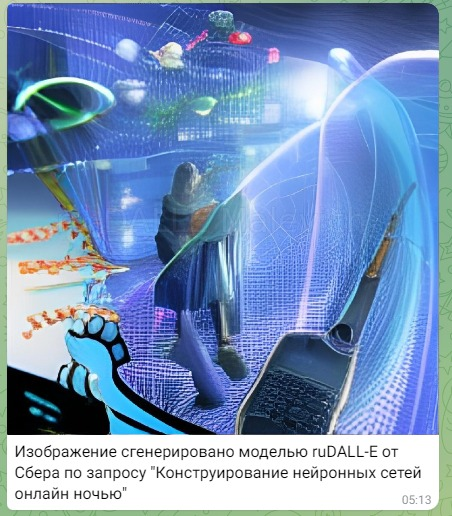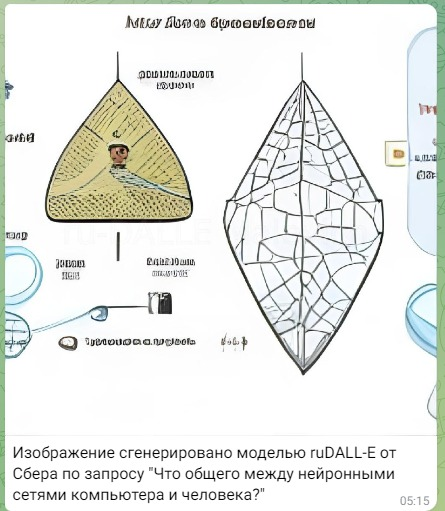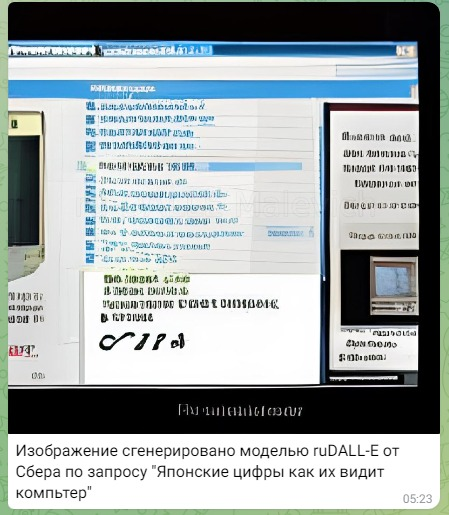